**Executed:** Mon Oct  3 17:49:58 2016

**Duration:** 8 seconds.

# usALEX-5samples - Template

> *This notebook is executed through [8-spots paper analysis](8-spots paper analysis.ipynb).*
> *For a direct execution, uncomment the cell below.*

In [1]:
ph_sel_name = "DexDem"

In [2]:
data_id = "12d"

In [3]:
# ph_sel_name = "all-ph"
# data_id = "7d"

## Load software and filenames definitions

In [4]:
from fretbursts import *

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.


--------------------------------------------------------------
 You are running FRETBursts (version 0.5.9).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------


In [5]:
init_notebook()
from IPython.display import display

Data folder:

In [6]:
data_dir = './data/singlespot/'

In [7]:
import os
data_dir = os.path.abspath(data_dir) + '/'
assert os.path.exists(data_dir), "Path '%s' does not exist." % data_dir

List of data files:

In [8]:
from glob import glob
file_list = sorted(f for f in glob(data_dir + '*.hdf5') if '_BKG' not in f)
## Selection for POLIMI 2012-11-26 datatset
labels = ['17d', '27d', '7d', '12d', '22d']
files_dict = {lab: fname for lab, fname in zip(labels, file_list)}
files_dict

{'12d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/007_dsDNA_12d_3nM_green100u_red40u.hdf5',
 '17d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/004_dsDNA_17d_green100u_red40u.hdf5',
 '22d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/008_dsDNA_22d_500pM_green100u_red40u.hdf5',
 '27d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/005_dsDNA_27d_green100u_red40u.hdf5',
 '7d': '/Users/anto/Google Drive/notebooks/multispot_paper/data/singlespot/006_dsDNA_7d_green100u_red40u.hdf5'}

In [9]:
ph_sel_map = {'all-ph': Ph_sel('all'), 'Dex': Ph_sel(Dex='DAem'), 
              'DexDem': Ph_sel(Dex='Dem')}
ph_sel = ph_sel_map[ph_sel_name]

data_id, ph_sel_name

('12d', 'DexDem')

## Data load

Initial loading of the data:

In [10]:
d = loader.photon_hdf5(filename=files_dict[data_id])

## Laser alternation selection

At this point we have only the timestamps and the detector numbers:

In [11]:
d.ph_times_t, d.det_t

([array([      42190,       56253,       56263, ..., 47999942928,
         47999959323, 48000016759])],
 [array([1, 0, 0, ..., 1, 1, 1], dtype=uint32)])

We need to define some parameters: donor and acceptor ch, excitation period and donor and acceptor excitiations:

In [12]:
d.add(det_donor_accept=(0, 1), alex_period=4000, D_ON=(2850, 580), A_ON=(900, 2580), offset=0)

We should check if everithing is OK with an alternation histogram:

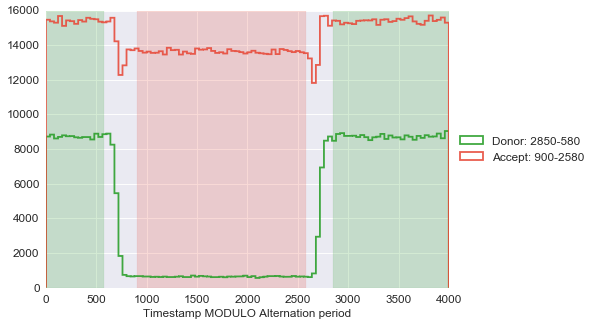

In [13]:
plot_alternation_hist(d)

If the plot looks good we can apply the parameters with:

In [14]:
loader.alex_apply_period(d)

# Total photons (after ALEX selection):   1,642,933
#  D  photons in D+A excitation periods:    404,153
#  A  photons in D+A excitation periods:  1,238,780
# D+A photons in  D  excitation period:   1,043,678
# D+A photons in  A  excitation period:     599,255



## Measurements infos

All the measurement data is in the `d` variable. We can print it:

In [15]:
d

singlespot_007_dsDNA_12d_3nM_green100u_red40u G1.000

Or check the **measurements duration**:

In [16]:
d.time_max

599.99949153749992

## Compute background

Compute the background using automatic threshold:

In [17]:
d.calc_bg(bg.exp_fit, time_s=60, tail_min_us='auto', F_bg=1.7)

 - Calculating BG rates ... 

[DONE]


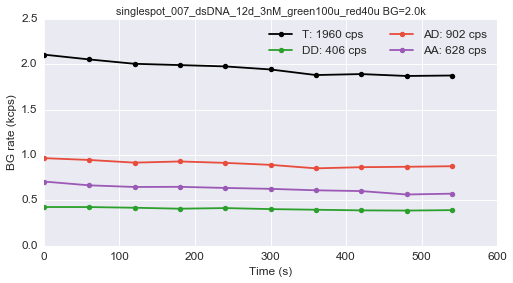

In [18]:
dplot(d, timetrace_bg)

In [19]:
d.rate_m, d.rate_dd, d.rate_ad, d.rate_aa

([1960.0483965382143],
 [406.04619715470801],
 [902.31032918273252],
 [628.25703861394027])

# Burst search and selection

In [20]:
bs_kws = dict(L=10, m=10, F=7, ph_sel=ph_sel)
d.burst_search(**bs_kws)

 - Performing burst search (verbose=False) ...

 - Recomputing background limits for DexDem ... 

[DONE]


 - Recomputing background limits for all ... 

[DONE]


 - Fixing  burst data to refer to ph_times_m ... 

[DONE]


[DONE]


 - Calculating burst periods ...

[DONE]


 - Counting D and A ph and calculating FRET ... 


   - Applying background correction.


   - Applying leakage correction.


   - Applying direct excitation correction.


   [DONE Counting D/A]


In [21]:
th1 = 30
ds = d.select_bursts(select_bursts.size, th1=30)

In [22]:
bursts = bext.burst_data(ds, include_bg=True, include_ph_index=True)

In [23]:
burst_fname = ('results/bursts_usALEX_{sample}_{ph_sel}_F{F:.1f}_m{m}_size{th}.csv'
               .format(sample=data_id, th=th1, **bs_kws))
burst_fname

'results/bursts_usALEX_12d_DexDem_F7.0_m10_size30.csv'

In [24]:
bursts.to_csv(burst_fname)

In [25]:
assert d.dir_ex == 0
assert d.leakage == 0

DexDem


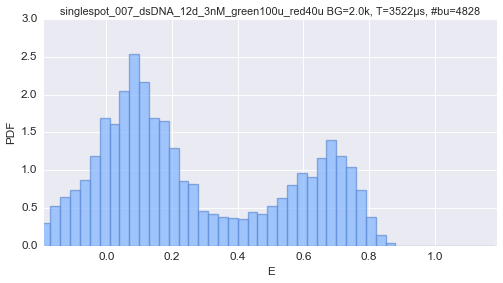

In [26]:
print(d.ph_sel)
dplot(d, hist_fret);

In [27]:
# if data_id in ['7d', '27d']:
#     ds = d.select_bursts(select_bursts.size, th1=20)
# else:
#     ds = d.select_bursts(select_bursts.size, th1=30)

In [28]:
ds = d.select_bursts(select_bursts.size, add_naa=False, th1=30)

In [29]:
n_bursts_all = ds.num_bursts[0]

In [30]:
def select_and_plot_ES(fret_sel, do_sel):
    ds_fret= ds.select_bursts(select_bursts.ES, **fret_sel)
    ds_do = ds.select_bursts(select_bursts.ES, **do_sel)
    bpl.plot_ES_selection(ax, **fret_sel)
    bpl.plot_ES_selection(ax, **do_sel)    
    return ds_fret, ds_do

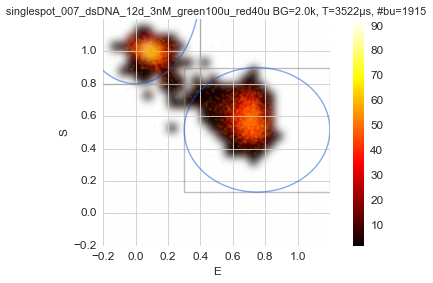

In [31]:
ax = dplot(ds, hist2d_alex, S_max_norm=2, scatter_alpha=0.1)

if data_id == '7d':
    fret_sel = dict(E1=0.60, E2=1.2, S1=0.2, S2=0.9, rect=False)
    do_sel = dict(E1=-0.2, E2=0.5, S1=0.8, S2=2, rect=True)    
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)
    
elif data_id == '12d':
    fret_sel = dict(E1=0.30,E2=1.2,S1=0.131,S2=0.9, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.8, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '17d':
    fret_sel = dict(E1=0.01, E2=0.98, S1=0.14, S2=0.88, rect=False)
    do_sel = dict(E1=-0.4, E2=0.4, S1=0.80, S2=2, rect=False)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)

elif data_id == '22d':
    fret_sel = dict(E1=-0.16, E2=0.6, S1=0.2, S2=0.80, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.85, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

elif data_id == '27d':
    fret_sel = dict(E1=-0.1, E2=0.5, S1=0.2, S2=0.82, rect=False)
    do_sel = dict(E1=-0.2, E2=0.4, S1=0.88, S2=2, rect=True)
    ds_fret, ds_do = select_and_plot_ES(fret_sel, do_sel)    

In [32]:
n_bursts_do = ds_do.num_bursts[0]
n_bursts_fret = ds_fret.num_bursts[0]

n_bursts_do, n_bursts_fret

(722, 1092)

In [33]:
d_only_frac = 1.*n_bursts_do/(n_bursts_do + n_bursts_fret)
print ('D-only fraction:', d_only_frac)

D-only fraction: 0.398015435502


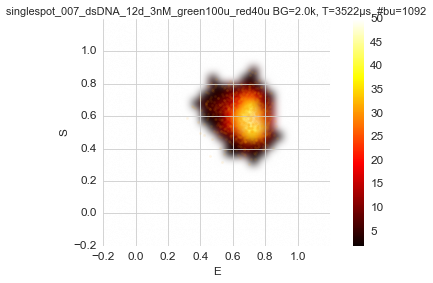

In [34]:
dplot(ds_fret, hist2d_alex, scatter_alpha=0.1);

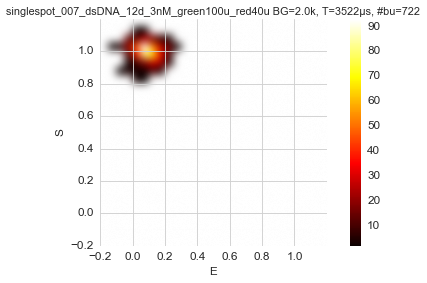

In [35]:
dplot(ds_do, hist2d_alex, S_max_norm=2, scatter=False);

# Donor Leakage fit

## Half-Sample Mode

Fit peak usng the mode computed with the half-sample algorithm ([Bickel 2005](http://arxiv.org/abs/math/0505419)).

In [36]:
def hsm_mode(s):
    """
    Half-sample mode (HSM) estimator of `s`.

    `s` is a sample from a continuous distribution with a single peak.
    
    Reference:
        Bickel, Fruehwirth (2005). arXiv:math/0505419
    """
    s = memoryview(np.sort(s))
    i1 = 0
    i2 = len(s)

    while i2 - i1 > 3:
        n = (i2 - i1) // 2
        w = [s[n-1+i+i1] - s[i+i1] for i in range(n)]
        i1 = w.index(min(w)) + i1
        i2 = i1 + n

    if i2 - i1 == 3:
        if s[i1+1] - s[i1] < s[i2] - s[i1 + 1]:
            i2 -= 1
        elif s[i1+1] - s[i1] > s[i2] - s[i1 + 1]:
            i1 += 1
        else:
            i1 = i2 = i1 + 1

    return 0.5*(s[i1] + s[i2])

In [37]:
E_pr_do_hsm = hsm_mode(ds_do.E[0])
print ("%s: E_peak(HSM) = %.2f%%" % (ds.ph_sel, E_pr_do_hsm*100))

DexDem: E_peak(HSM) = 8.70%


## Gaussian Fit

Fit the histogram with a gaussian:

In [38]:
E_fitter = bext.bursts_fitter(ds_do, weights=None)
E_fitter.histogram(bins=np.arange(-0.2, 1, 0.03))

In [39]:
E_fitter.fit_histogram(model=mfit.factory_gaussian())
E_fitter.params

,amplitude,center,sigma
0,0.983358,0.091178,0.0639288


In [40]:
res = E_fitter.fit_res[0]
res.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr
amplitude    0.9834     -inf      inf  0.02692     True     None
center      0.09118       -1        2 0.002021     True     None
fwhm         0.1505     -inf      inf 0.004759    False 2.3548200*sigma
height        6.137     -inf      inf    0.168    False 0.3989423*amplitude/max(1.e-15, sigma)
sigma       0.06393        0      inf 0.002021     True     None


In [41]:
E_pr_do_gauss = res.best_values['center']
E_pr_do_gauss

0.09117796673850886

## KDE maximum

In [42]:
bandwidth = 0.03
E_range_do = (-0.1, 0.15)
E_ax = np.r_[-0.2:0.401:0.0002]

E_fitter.calc_kde(bandwidth=bandwidth)
E_fitter.find_kde_max(E_ax, xmin=E_range_do[0], xmax=E_range_do[1])
E_pr_do_kde = E_fitter.kde_max_pos[0]
E_pr_do_kde

0.091600000000008341

## Leakage summary

Gauss: 9.12%
  KDE: 9.16%
  HSM: 8.70%


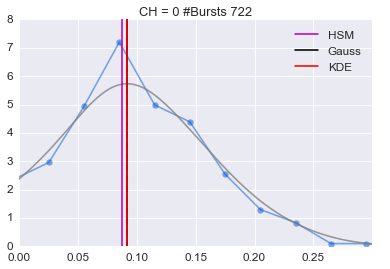

In [43]:
mfit.plot_mfit(ds_do.E_fitter, plot_kde=True, plot_model=False)
plt.axvline(E_pr_do_hsm, color='m', label='HSM')
plt.axvline(E_pr_do_gauss, color='k', label='Gauss')
plt.axvline(E_pr_do_kde, color='r', label='KDE')
plt.xlim(0, 0.3)
plt.legend()
print('Gauss: %.2f%%\n  KDE: %.2f%%\n  HSM: %.2f%%' % 
      (E_pr_do_gauss*100, E_pr_do_kde*100, E_pr_do_hsm*100))

# Burst size distribution

In [44]:
nt_th1 = 50

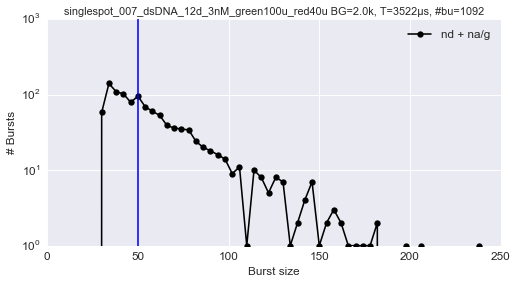

In [45]:
dplot(ds_fret, hist_size, which='all', add_naa=False)
xlim(-0, 250)
plt.axvline(nt_th1)

In [46]:
Th_nt = np.arange(35, 120)
nt_th = np.zeros(Th_nt.size)
for i, th in enumerate(Th_nt):
    ds_nt = ds_fret.select_bursts(select_bursts.size, th1=th)
    nt_th[i] = (ds_nt.nd[0]  + ds_nt.na[0]).mean() - th

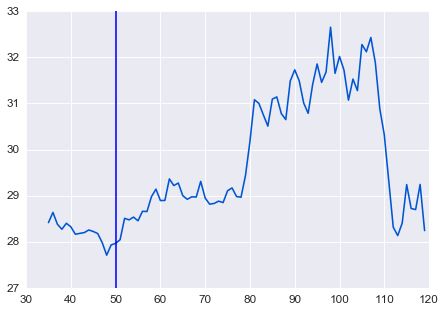

In [47]:
plt.figure()
plot(Th_nt, nt_th)
plt.axvline(nt_th1)

In [48]:
nt_mean = nt_th[np.where(Th_nt == nt_th1)][0]
nt_mean

27.970313445762358

# Fret fit

Max position of the Kernel Density Estimation (KDE):

In [49]:
E_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, bandwidth=bandwidth, weights='size')
E_fitter = ds_fret.E_fitter

In [50]:
E_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])

In [51]:
E_fitter.fit_histogram(mfit.factory_gaussian(center=0.5))

In [52]:
display(E_fitter.params*100)

,amplitude,center,sigma
0,95.0811,70.6765,7.55688


DexDem
KDE peak 71.40 


,amplitude,center,sigma
0,95.0811,70.6765,7.55688


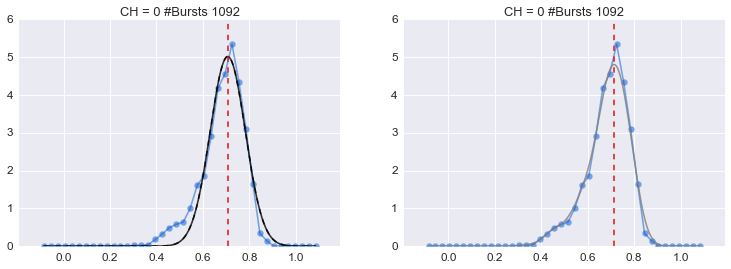

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(E_fitter, ax=ax[0])
mfit.plot_mfit(E_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print ('%s\nKDE peak %.2f ' % (ds_fret.ph_sel, E_pr_fret_kde*100))
display(E_fitter.params*100)

In [54]:
# ds_fret.add(E_fitter = E_fitter)
# dplot(ds_fret, hist_fret_kde, weights='size', bins=np.r_[-0.2:1.2:bandwidth], bandwidth=bandwidth);
# plt.axvline(E_pr_fret_kde, ls='--', color='r')
# print ds_fret.ph_sel, E_pr_fret_kdedd

Weighted mean of $E$ of each burst:

In [55]:
ds_fret.fit_E_m(weights='size')

array([ 0.6840553])

Gaussian fit (no weights):

In [56]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.03], weights=None)

array([ 0.69753372])

Gaussian fit (using burst size as weights):

In [57]:
ds_fret.fit_E_generic(fit_fun=bl.gaussian_fit_hist, bins=np.r_[-0.1:1.1:0.005], weights='size')

array([ 0.70599476])

In [58]:
E_kde_w = E_fitter.kde_max_pos[0]
E_gauss_w = E_fitter.params.loc[0, 'center']
E_gauss_w_sig = E_fitter.params.loc[0, 'sigma']
E_gauss_w_err = float(E_gauss_w_sig/np.sqrt(ds_fret.num_bursts[0]))
E_kde_w, E_gauss_w, E_gauss_w_sig, E_gauss_w_err

(0.71400000000002617,
 0.7067648333572027,
 0.0755687846951485,
 0.0022868154553912345)

# Stoichiometry fit

Max position of the Kernel Density Estimation (KDE):

In [59]:
S_pr_fret_kde = bext.fit_bursts_kde_peak(ds_fret, burst_data='S', bandwidth=0.03) #weights='size', add_naa=True)
S_fitter = ds_fret.S_fitter

In [60]:
S_fitter.histogram(bins=np.r_[-0.1:1.1:0.03])
S_fitter.fit_histogram(mfit.factory_gaussian(), center=0.5)

DexDem
KDE peak 55.92 


,amplitude,center,sigma
0,101.486,58.7225,10.1999


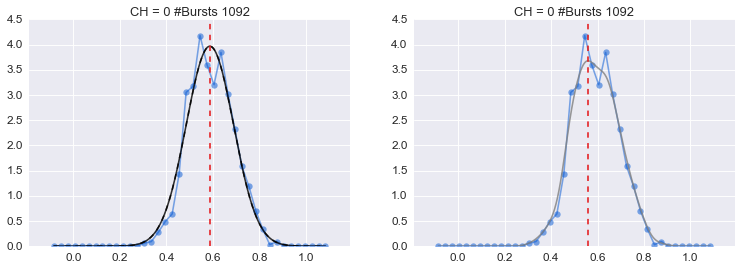

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5))
mfit.plot_mfit(S_fitter, ax=ax[0])
mfit.plot_mfit(S_fitter, plot_model=False, plot_kde=True, ax=ax[1])
print ('%s\nKDE peak %.2f ' % (ds_fret.ph_sel, S_pr_fret_kde*100))
display(S_fitter.params*100)

In [62]:
S_kde = S_fitter.kde_max_pos[0]
S_gauss = S_fitter.params.loc[0, 'center']
S_gauss_sig = S_fitter.params.loc[0, 'sigma']
S_gauss_err = float(S_gauss_sig/np.sqrt(ds_fret.num_bursts[0]))
S_kde, S_gauss, S_gauss_sig, S_gauss_err

(0.55920000000002168,
 0.5872253212916171,
 0.10199856405498386,
 0.0030866169629379346)

The Maximum likelihood fit for a Gaussian population is the mean:

In [63]:
S = ds_fret.S[0]
S_ml_fit = (S.mean(), S.std())
S_ml_fit

(0.59165831477348163, 0.096484341378571412)

Computing the weighted mean and weighted standard deviation we get:

In [64]:
weights = bl.fret_fit.get_weights(ds_fret.nd[0], ds_fret.na[0], weights='size', naa=ds_fret.naa[0], gamma=1.)
S_mean = np.dot(weights, S)/weights.sum()
S_std_dev = np.sqrt(
        np.dot(weights, (S - S_mean)**2)/weights.sum())
S_wmean_fit = [S_mean, S_std_dev]
S_wmean_fit

[0.57760995098884294, 0.091119738858254154]

# Save data to file

In [65]:
sample = data_id

The following string contains the list of variables to be saved. When saving, the order of the variables is preserved.

In [66]:
variables = ('sample n_bursts_all n_bursts_do n_bursts_fret '
             'E_kde_w E_gauss_w E_gauss_w_sig E_gauss_w_err S_kde S_gauss S_gauss_sig S_gauss_err '
             'E_pr_do_kde E_pr_do_hsm E_pr_do_gauss nt_mean\n')

This is just a trick to format the different variables:

In [67]:
variables_csv = variables.replace(' ', ',')
fmt_float = '{%s:.6f}'
fmt_int = '{%s:d}'
fmt_str = '{%s}'
fmt_dict = {**{'sample': fmt_str}, 
            **{k: fmt_int for k in variables.split() if k.startswith('n_bursts')}}
var_dict = {name: eval(name) for name in variables.split()}
var_fmt = ', '.join([fmt_dict.get(name, fmt_float) % name for name in variables.split()]) + '\n'
data_str = var_fmt.format(**var_dict)

print(variables_csv)
print(data_str)

sample,n_bursts_all,n_bursts_do,n_bursts_fret,E_kde_w,E_gauss_w,E_gauss_w_sig,E_gauss_w_err,S_kde,S_gauss,S_gauss_sig,S_gauss_err,E_pr_do_kde,E_pr_do_hsm,E_pr_do_gauss,nt_mean

12d, 1915, 722, 1092, 0.714000, 0.706765, 0.075569, 0.002287, 0.559200, 0.587225, 0.101999, 0.003087, 0.091600, 0.086989, 0.091178, 27.970313



In [68]:
# NOTE: The file name should be the notebook name but with .csv extension
with open('results/usALEX-5samples-PR-raw-%s.csv' % ph_sel_name, 'a') as f:
    f.seek(0, 2)
    if f.tell() == 0:
        f.write(variables_csv)
    f.write(data_str)